In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.colors as mc
import matplotlib
from adjustText import adjust_text
from gwaslab.util_in_get_sig import annogene
from gwaslab.viz_aux_reposition_text import adjust_text_position
from gwaslab.viz_aux_save_figure import save_figure
from gwaslab.viz_plot_mqqplot import _process_highlight
from gwaslab.g_Log import Log
from gwaslab.util_in_calculate_power import get_beta
from gwaslab.util_in_calculate_power import get_beta_binary
from gwaslab.util_in_fill_data import filldata

def plottrumpet(mysumstats,
                snpid="SNPID",
                mode="q",
                chrom="CHR",
                pos="POS",
                n="N",
                p="P",
                maf="MAF",
                eaf="EAF",
                beta="BETA",
                ts=None,
                anno=None,
                prevalence=None,
                or_to_rr=False,
                ncase=None,
                ncontrol=None, 
                sig_level=5e-8,
                p_level=5e-8,
                anno_y = 1,
                anno_x = 0.01,                
                maf_range=None,
                beta_range=None, 
                n_matrix=1000,
                xscale="log",
                yscale_factor=1,
                cmap="cool",
                ylim=None,
                xlim=None,
                markercolor="#597FBD",
                hue=None,
                highlight = None,
                highlight_chrpos = False,
                highlight_color="#CB132D",
                highlight_windowkb = 500,
                highlight_anno_args = None,
                pinpoint= None,
                pinpoint_color ="red",
                scatter_args=None,
                fontsize=15,
                font_family="Arial",
                size= "ABS_BETA",
                sizes=None,
                save=False,
                save_args=None,
                figargs=None,
                build="99",
                anno_set=None,
                anno_alias=None,
                anno_d=None,
                anno_args=None,
                anno_style="expand",
                anno_source = "ensembl",
                anno_max_iter=100,
                arm_scale=1,
                repel_force=0.01,
                ylabel="Effect size",
                xlabel="Minor allele frequency",
                xticks = None,
                xticklabels = None,
                yticks = None,
                yticklabels=None,
                sort="beta",
                verbose=True,
                log=Log()):
    
    #Checking columns#################################################################################################################
    matplotlib.rc('font', family=font_family)
    if sizes is None:
        sizes = (20,80)
    if anno_args is None:
        anno_args={"fontsize":12,"fontstyle":"italic"}
    if anno_set is None:
        anno_set=list()
    if anno_alias is None:
        anno_alias=dict()
    if anno_d is None:
        anno_d=dict()
    if ts is None:
        ts = [0.2,0.4,0.6,0.8]
    if xticks is None:
        if xscale== "log":
            xticks = [0.001,0.01,0.05,0.1,0.2,0.5]
            xticklabels = xticks
        else:
            xticks = [0,0.01,0.05,0.1,0.2,0.5]
            xticklabels = xticks            
    if figargs is None:
        figargs={"figsize":(10,8)}
    if scatter_args is None:
        scatter_args ={}
    if hue is not None:
        scatter_args["hue"]=hue
    if markercolor is not None:
        scatter_args["color"]=markercolor
    if highlight is None:
        highlight = list()
    if pinpoint is None:
        pinpoint = list()  
    #Checking columns#################################################################################################################
    log.write("Start to create trumpet plot...", verbose=verbose)
    
    #parameter check##################################################################################################################
    if (beta not in mysumstats.columns) or (eaf not in mysumstats.columns):
        log.write(" -No EAF or BETA columns. Skipping...", verbose=verbose)
        return None
    if mode=="b":
        if ncase is None or ncontrol is None:
            log.write(" -No scase or scontrol. Skipping...", verbose=verbose)
            return None
        if prevalence is None:
                prevalence= ncase/(ncase + ncontrol)
                log.write(" -Prevalence is not given. Estimating based on scase and scontrol :{}...".format(prevalence), verbose=verbose)
    
    #print settings##################################################################################################################

    log.write(" -Settings:", verbose=verbose)
    log.write("  -Mode: {}".format(mode), verbose=verbose)
    if mode == "q" :
        log.write("  -N: {}".format(n), verbose=verbose)
    if mode == "b" :
        log.write("  -N_CASE: {}".format(ncase), verbose=verbose)
        log.write("  -N_CONTROL: {}".format(ncontrol), verbose=verbose)
        log.write("  -PREVALENCE: {}".format(prevalence), verbose=verbose)
    log.write("  -BETA: {}".format(beta), verbose=verbose)
    log.write("  -Significance level: {}".format(sig_level), verbose=verbose)
    log.write("  -Power thresholds: {}".format(ts), verbose=verbose)
    log.write("  -Power line smoothness: {}".format(n_matrix), verbose=verbose)
    
    #loading columns #################################################################################################################
    cols_to_use = [snpid, beta, eaf, n, p]
    
    if len(highlight)>0: 
        cols_to_use.append(pos)
        cols_to_use.append(chrom)
    
    if anno is not None:
        if anno != "GENENAME":
            if anno!=True:
                log.write(" -Loading column {} for annotation...".format(anno), verbose=verbose)
                if anno not in cols_to_use:
                    cols_to_use.append(anno)
        else:
            cols_to_use.append(pos) if pos not in cols_to_use else cols_to_use
            cols_to_use.append(chrom) if chrom not in cols_to_use else cols_to_use

    print('columns', cols_to_use)

    if size != "ABS_BETA":
        if size not in cols_to_use:
            cols_to_use.append(size)
    if "hue" in scatter_args.keys():
        cols_to_use.append(scatter_args["hue"]) 
    #filter by p #################################################################################################################
    if p in mysumstats.columns:
        sumstats = mysumstats.loc[mysumstats[p]< p_level,cols_to_use ].copy()
        log.write(" -Excluding variants with P values > {}".format(p_level), verbose=verbose)
    else:
        cols_to_use.remove(p)
        sumstats = mysumstats[[beta,eaf,n]].copy()
    log.write(" -Plotting {} variants...".format(len(sumstats)), verbose=verbose)
    
    #add maf column #################################################################################################################
    if maf not in sumstats.columns:
        sumstats = filldata(sumstats,to_fill=["MAF"],verbose=False)
        is_filpped = (sumstats["MAF"] < sumstats[eaf]) & (sumstats[eaf] > 0.5)& (sumstats["MAF"] < 0.5)
        log.write(" -Flipping {} variants...".format(sum(is_filpped)), verbose=verbose)
        sumstats.loc[is_filpped, beta] = -sumstats.loc[is_filpped, beta]
    
    #configure n #################################################################################################################
    if mode=="q":
        if n == "N":
            n = sumstats["N"].median() 
        elif n == "max":
            n = sumstats["N"].max() 
        elif n == "min":
            n = sumstats["N"].min() 
        elif n == "median":
            n = sumstats["N"].median() 
        elif n == "mean":
            n = sumstats["N"].mean() 
        log.write(" -N for power calculation: {}".format(n), verbose=verbose)

    #configure beta and maf range ###################################################################################################
    if maf_range is None:
        maf_min_power = np.floor( -np.log10(sumstats[maf].min())) + 1
        maf_range=(min(np.power(10.0,-maf_min_power),np.power(10.0,-4)),0.5)
    if beta_range is None:
        if sumstats[beta].max()>3:
            beta_range=(0.0001,sumstats[beta].max())
        else:
            beta_range=(0.0001,3)
    
    #configure power threshold###################################################################################################
    if ts is None:
        ts=[0.3,0.5,0.8]
    
    #configure colormap##########################################################################################################
    cmap_to_use = plt.cm.get_cmap(cmap)
    if cmap_to_use.N >100:
        rgba = cmap_to_use(ts)
    else:
        rgba = cmap_to_use(range(len(ts)))
    
    output_hex_colors=[]
    for i in range(len(rgba)):
        output_hex_colors.append(mc.to_hex(rgba[i]))
    output_hex_colors

    if len(highlight)>0:
        sumstats["HUE"] = pd.NA
        sumstats["HUE"] = sumstats["HUE"].astype("Int64")
        sumstats = _process_highlight(sumstats=sumstats, 
                                                    highlight=highlight, 
                                                    highlight_chrpos=highlight_chrpos, 
                                                    highlight_windowkb=highlight_windowkb, 
                                                    snpid=snpid, 
                                                    chrom=chrom, 
                                                    pos=pos)
    ##################################################################################################
    fig, ax = plt.subplots(**figargs)
    
    ##creating power line############################################################################################
    if mode=="q":
        for i,t in enumerate(ts):
            xpower = get_beta(mode="q",          
                            eaf_range=maf_range,
                            beta_range=beta_range, 
                            n=n,
                            t=t,
                            sig_level=sig_level,
                            n_matrix=n_matrix)
            xpower2 = xpower.copy()
            xpower2[1] = -xpower2[1] 
            xpower2[1] = xpower2[1] * yscale_factor
            xpower[1] = xpower[1] * yscale_factor
            lines = LineCollection([xpower2,xpower], label=t,color=output_hex_colors[i],zorder=0)
            ax.add_collection(lines)
    else:
        for i,t in enumerate(ts):
            xpower = get_beta_binary(        
                            eaf_range=maf_range,
                            beta_range=beta_range, 
                            prevalence=prevalence,
                            or_to_rr = or_to_rr,
                            ncase=ncase, 
                            ncontrol=ncontrol, 
                            t=t,
                            sig_level=sig_level,
                            n_matrix=n_matrix)
            xpower2 = xpower.copy()
            xpower2[1] = -xpower2[1] 
            xpower2[1] = xpower2[1] * yscale_factor
            xpower[1] = xpower[1] * yscale_factor
            lines = LineCollection([xpower2,xpower], label=t,color=output_hex_colors[i])
            ax.add_collection(lines)


    ###################################################################################################
    # get abs  and convert using scaling factor
    sumstats[beta] = sumstats[beta]*yscale_factor
    sumstats["ABS_BETA"] = sumstats[beta].abs()

    ##################################################################################################
    size_norm = (sumstats["ABS_BETA"].min(), sumstats["ABS_BETA"].max())
    ## if highlight  ##################################################################################################
    dots = sns.scatterplot(data=sumstats,
                    x=maf,
                    y=beta,
                    size=size, 
                    ax=ax, 
                    sizes=sizes,
                    size_norm=size_norm,
                    legend=True, 
                    edgecolor="black",
                    alpha=0.8,
                    zorder=2,
                    **scatter_args)
    
    if len(highlight) >0:
        
        legend = None
        style=None
        linewidth=0
        edgecolor="black"

        if pd.api.types.is_list_like(highlight[0]) and highlight_chrpos==False:
            for i, highlight_set in enumerate(highlight):
                scatter_args["color"]=highlight_color[i%len(highlight_color)]
                log.write(" -Highlighting set {} target loci...".format(i+1),verbose=verbose)
                sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==i], x=maf,
                    y=beta,
                    legend=legend,
                    style=style,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    linewidth=linewidth,
                    zorder=3+i,
                    ax=ax,edgecolor=edgecolor,**scatter_args)  

        else:
            log.write(" -Highlighting target loci...",verbose=verbose)
            scatter_args["color"]=highlight_color
            sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==0], x=maf,
                    y=beta,
                legend=legend,
                size=size,
                sizes=sizes,
                size_norm=size_norm,
                zorder=3,
                ax=ax,
                edgecolor="black",
                **scatter_args)  
    ####################################################################################################################
    if len(pinpoint)>0:
        legend = None
        style=None
        linewidth=0
        edgecolor="black"
        if pd.api.types.is_list_like(pinpoint[0]):

            for i, pinpoint_set in enumerate(pinpoint):
                scatter_args["color"]=pinpoint_color[i%len(pinpoint_color)]
                if sum(sumstats[snpid].isin(pinpoint_set))>0:
                    to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint_set),:]
                    log.write(" -Pinpointing set {} target vairants...".format(i+1),verbose=verbose)
                    sns.scatterplot(data=to_pinpoint, 
                    x=maf,
                    y=beta,
                    legend=legend,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    zorder=3,
                    ax=ax,
                    edgecolor="black",
                    **scatter_args)  
                    #ax.scatter(to_pinpoint[maf],to_pinpoint[beta],color=pinpoint_color[i%len(pinpoint_color)],zorder=100,s=to_pinpoint[size])
                else:
                    log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
        else:
            scatter_args["color"]=pinpoint_color
            if sum(sumstats[snpid].isin(pinpoint))>0:
                to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint),:]
                log.write(" -Pinpointing target vairants...",verbose=verbose)
                sns.scatterplot(data=to_pinpoint, x=maf,
                    y=beta,
                    legend=legend,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    zorder=3,
                    ax=ax,
                    edgecolor="black",
                    **scatter_args)  
                #ax.scatter(to_pinpoint[maf],to_pinpoint[beta],color=pinpoint_color[i%len(pinpoint_color)],zorder=100,s=to_pinpoint[size])
            else:
                log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
    
    ####################################################################################################################
    
    #second_legend = ax.legend(title="Power", loc="upper right",fontsize =fontsize,title_fontsize=fontsize)
    
    h,l = ax.get_legend_handles_labels()
    if len(ts)>0:
        l1 = ax.legend(h[:int(len(ts))],l[:int(len(ts))], title="Power", loc="upper right",fontsize =fontsize,title_fontsize=fontsize)
        for line in l1.get_lines():
            line.set_linewidth(5.0)
    if hue is None:
        l2 = ax.legend(h[int(len(ts)):],l[int(len(ts)):], title=size, loc="lower right",fontsize =fontsize,title_fontsize=fontsize)
    else:
        l2 = ax.legend(h[int(len(ts)):],l[int(len(ts)):], title=None, loc="lower right",fontsize =fontsize,title_fontsize=fontsize)
    if len(ts)>0:
        ax.add_artist(l1)
    #first_legend = ax.legend(handles=dots, loc="lower right" ,title=size,fontsize =fontsize,title_fontsize=fontsize)
    #ax.add_artist(first_legend)
    ##################################################################################################

    ax.tick_params(axis='y', labelsize=fontsize)

    ax.axhline(y=0,color="grey",linestyle="dashed")
    
    if xscale== "log":
        ax.set_xscale('log')
        rotation=0
        ax.set_xticks(xticks,xticklabels,fontsize=fontsize,rotation=rotation)
        ax.set_xlim(min(sumstats[maf].min()/2,0.001/2),0.52)
    else:
        rotation=90    
        ax.set_xticks(xticks,xticklabels,fontsize=fontsize,rotation=rotation)
        ax.set_xlim(-0.02,0.52)
        
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)

    if yticks is not None:
        ax.set_yticks(yticks, yticklabels)

    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(xlabel,fontsize=fontsize)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)

    ############  Annotation ##################################################################################################
    if anno is not None:
        if anno in sumstats.columns or anno=="GENENAME" :
            variants_toanno = sumstats.copy()
            variants_toanno = variants_toanno.loc[ variants_toanno[beta].abs() > anno_y,:]
            variants_toanno = variants_toanno.loc[ variants_toanno[maf] < anno_x,:]
            if (variants_toanno.empty is not True) and anno=="GENENAME":
                variants_toanno = annogene(variants_toanno,
                                    id=snpid,
                                    chrom=chrom,
                                    pos=pos,
                                    log=log,
                                    build=build,
                                    source=anno_source,
                                    verbose=verbose).rename(columns={"GENE":"GENENAME"})

            texts_u=[]
            texts_d=[]

            if len(variants_toanno)>0:
                maxy = variants_toanno[beta].abs().max()
                #maxy = max(variants_toanno[beta].abs().max(),1.5)
                variants_toanno["ADJUSTED_i"] = np.nan 
                y_span = 0.5
                
                if sort == "beta" : 
                    variants_toanno = variants_toanno.sort_values(by=beta, key= np.abs, ascending = False)
                else:
                    variants_toanno = variants_toanno.sort_values(by=maf, key= np.abs, ascending = True)
                
                if anno_style == "expand":

                    min_factor=None
                    
                    if len(variants_toanno.loc[variants_toanno[beta]>0, "ADJUSTED_i"])>1:
                        variants_toanno.loc[variants_toanno[beta]>0, "ADJUSTED_i"] = adjust_text_position(variants_toanno.loc[variants_toanno[beta]>0,maf].values.copy(), 
                                                                                y_span, 
                                                                                repel_force=repel_force,
                                                                                max_iter=anno_max_iter,
                                                                                log=log,
                                                                                amode=xscale,
                                                                                verbose=verbose,min_factor=min_factor)

                    if len(variants_toanno.loc[variants_toanno[beta]<0, "ADJUSTED_i"])>1:
                        variants_toanno.loc[variants_toanno[beta]<0, "ADJUSTED_i"] = adjust_text_position(variants_toanno.loc[variants_toanno[beta]<0,maf].values.copy(), 
                                                                y_span, 
                                                                repel_force=repel_force,
                                                                max_iter=anno_max_iter,
                                                                log=log,
                                                                amode=xscale,
                                                                verbose=verbose,min_factor=min_factor)

                
                for variants_toanno_half in [variants_toanno.loc[variants_toanno[beta]<0,:], variants_toanno.loc[variants_toanno[beta]>0,:]]:
                    if len(variants_toanno_half)<1:
                        continue
                    last_pos = min(variants_toanno_half[maf])/2
                    for index, row in variants_toanno_half.iterrows():
                        
                        armB_length_in_point = ax.transData.transform((0,1.1*maxy))[1]-ax.transData.transform((0, abs(row[beta])))[1]
                        armB_length_in_point = armB_length_in_point*arm_scale

                        if anno_style == "right" :
                            #right style
                            if row[maf]>last_pos*(repel_force+1):
                                last_pos=row[maf]
                            else:
                                last_pos*= (repel_force+1)
                        elif anno_style == "expand" :
                            last_pos = row["ADJUSTED_i"]

                        if anno_style == "right"  or anno_style == "expand":
                            if row[beta] >0 :
                                texts_u.append(ax.annotate(row[anno], xy=(row[maf], row[beta]),xytext=(last_pos , 1.2*maxy),
                                                        arrowprops=dict(relpos=(0,0),arrowstyle="-|>",facecolor='black',connectionstyle="arc,angleA=-90,armA={},angleB=0,armB=0,rad=0".format(armB_length_in_point)),rotation=90,
                                                        ha="left",va="bottom",**anno_args))
                            else:
                                texts_d.append(ax.annotate(row[anno], xy=(row[maf], row[beta]),xytext=(last_pos , -1.2*maxy),
                                                        arrowprops=dict(relpos=(0,1),arrowstyle="-|>",facecolor='black',connectionstyle="arc,angleA=90,armA={},angleB=0,armB=0,rad=0".format(armB_length_in_point)),rotation=90,
                                                        ha="left",va="top",**anno_args))
                        
                        if anno_style=="tight":
                            texts_d.append(ax.text(row[maf], row[beta], row[anno]))

                if anno_style=="tight":
                    adjust_text(texts_d, 
                                autoalign =True,
                                precision =0.001,
                                lim=1000, 
                                expand_text=(0.5,0.5), 
                                expand_points=(0.5,0.5),
                                force_objects=(0.5,0.5), 
                                ax=ax)
    

    ############  Annotation ##################################################################################################
    if mode=="q":
        save_figure(fig, save, keyword="trumpet_q",save_args=save_args, log=log, verbose=verbose)
    elif mode=="b":
        save_figure(fig, save, keyword="trumpet_b",save_args=save_args, log=log, verbose=verbose)

    log.write("Finished creating trumpet plot!", verbose=verbose)
    return fig

####################################################################


In [2]:
import gwaslab as gl

mysumstats = gl.Sumstats(
    "/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed/ds_results_glm.PHENO1.glm.logistic.hybrid",
    fmt  ="plink2_firth",
    rsid="SNP",
    chrom="CHR",
    pos  ="POS",
    ea="A1",
    nea="A2",
    eaf="freq",
    beta="b",
    se="se",
    p="p",  
    n="N",
    sep="\t",
    z="Z_STAT",
    build="hg38")

mysumstats.data['SNPID'] = mysumstats.data['CHR'].astype(str) + ':' + mysumstats.data['POS'].astype(str) + ':' + mysumstats.data['EA'].astype(str) + ':' + mysumstats.data['NEA'].astype(str)
mysumstats.data['CHR'] = mysumstats.data['CHR'].astype(int)

# load frequencies
df_freq = pd.read_csv(
    '/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed/ds_results.frq',
    sep="\s+",
    usecols=['SNP', 'MAF']
)

mysumstats.data = mysumstats.data.merge(df_freq, left_on='rsID', right_on='SNP', how='left')
mysumstats.data = mysumstats.data.drop(columns=['SNP'])
mysumstats.data

2024/10/15 16:11:08 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/15 16:11:08 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/15 16:11:08 Start to load format from formatbook....
2024/10/15 16:11:08  -plink2_firth format meta info:
2024/10/15 16:11:08   - format_name  : PLINK2 .glm.firth, .glm.logistic[.hybrid]
2024/10/15 16:11:08   - format_source  : https://www.cog-genomics.org/plink/2.0/formats
2024/10/15 16:11:08   - format_version  : Alpha 3.3 final (3 Jun)
2024/10/15 16:11:08   - last_check_date  :  20220806
2024/10/15 16:11:08  -plink2_firth to gwaslab format dictionary:
2024/10/15 16:11:08   - plink2_firth keys: ID,#CHROM,POS,REF,ALT,A1,OBS_CT,A1_FREQ,BETA,LOG(OR)_SE,SE,Z_STAT,P,LOG10_P,MACH_R2,OR,L95,U95
2024/10/15 16:11:08   - gwaslab values: SNPID,CHR,POS,REF,ALT,EA,N,EAF,BETA,SE,SE,Z,P,MLOG10P,INFO,OR,OR_95L,OR_95U
2024/10/15 16:11:08 Start to initialize gl.Sumstats from file :/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData

,rsID,CHR,POS,EA,NEA,EAF,BETA,SE,Z,P,OR_95L,OR_95U,N,STATUS,ALT,SNPID,MAF
0,rs61769339,1,727242,A,G,0.181916,0.031144,0.035231,0.883995,0.376699,-0.037907,0.100195,11170,3899999,A,1:727242:A:G,0.18190
1,rs61769340,1,727717,G,C,0.235228,0.016814,0.032058,0.524490,0.599938,-0.046018,0.079646,11170,3899999,G,1:727717:G:C,0.23520
2,rs61769351,1,758443,C,G,0.185900,0.020681,0.034927,0.592114,0.553774,-0.047775,0.089137,11170,3899999,C,1:758443:C:G,0.18590
3,rs142559957,1,769257,A,G,0.055013,-0.081504,0.060305,-1.351530,0.176527,-0.199701,0.036692,11170,3899999,A,1:769257:A:G,0.05501
4,rs58276399,1,796338,C,T,0.208460,-0.005769,0.033427,-0.172597,0.862968,-0.071286,0.059747,11170,3899999,C,1:796338:C:T,0.20850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5931176,rs7289043,22,50789831,G,A,0.057565,-0.016376,0.058171,-0.281519,0.778312,-0.130389,0.097636,11170,3899999,G,22:50789831:G:A,0.05756
5931177,rs201882178,22,50790460,G,T,0.251567,0.021227,0.031231,0.679681,0.496707,-0.039984,0.082438,11170,3899999,G,22:50790460:G:T,0.25160
5931178,rs80012748,22,50790482,A,G,0.201835,0.041492,0.033957,1.221880,0.221753,-0.025063,0.108046,11170,3899999,A,22:50790482:A:G,0.20180
5931179,rs9616985,22,50791377,C,T,0.057565,-0.016376,0.058171,-0.281519,0.778312,-0.130389,0.097636,11170,3899999,C,22:50791377:C:T,0.05756


In [3]:
import pandas as pd
highlighted = pd.read_csv('/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed/snps_annotated.csv', sep='\t')
highlighted = pd.merge(highlighted, mysumstats.data[['rsID', 'SNPID', 'CHR', 'POS']], left_on='SNP', right_on='rsID', how='inner')
highlighted

,SNP,GENE,rsID,SNPID,CHR,POS
0,rs3747973,NUCKS1,rs3747973,1:205708020:A:G,1,205708020
1,rs74990530,ITPKB,rs74990530,1:226728477:T:A,1,226728477
2,rs34311866,TMEM175,rs34311866,4:958159:C:T,4,958159
3,rs356182,SNCA,rs356182,4:89704960:G:A,4,89704960
4,rs7681440,SNCA,rs7681440,4:89835399:C:G,4,89835399
5,rs1846190,HLA-DQA1,rs1846190,6:32616036:A:G,6,32616036
6,rs4909940,RNF141,rs4909940,11:10521749:T:C,11,10521749
7,rs56328224,PLEKHM1,rs56328224,17:45495053:T:C,17,45495053
8,rs72843781,MED13,rs72843781,17:62016181:C:A,17,62016181
9,rs8087199,RIT2,rs8087199,18:43094076:A:G,18,43094076


2024/10/15 16:12:12 Start to create trumpet plot...
2024/10/15 16:12:12  -Settings:
2024/10/15 16:12:12   -Mode: b
2024/10/15 16:12:12   -N_CASE: 48060
2024/10/15 16:12:12   -N_CONTROL: 6364
2024/10/15 16:12:12   -PREVALENCE: 0.05
2024/10/15 16:12:12   -BETA: BETA
2024/10/15 16:12:12   -Significance level: 5e-08
2024/10/15 16:12:12   -Power thresholds: [0.2, 0.4, 0.6, 0.8]
2024/10/15 16:12:12   -Power line smoothness: 2000
columns ['SNPID', 'BETA', 'EAF', 'N', 'P', 'POS', 'CHR']
2024/10/15 16:12:12  -Excluding variants with P values > 5e-08
2024/10/15 16:12:12  -Plotting 880 variants...
2024/10/15 16:12:12  -Flipping 0 variants...
2024/10/15 16:12:12  -Updating eaf-beta matrix...
2024/10/15 16:12:12  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....


/tmp/ipykernel_15850/271363832.py:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_to_use = plt.cm.get_cmap(cmap)


2024/10/15 16:12:13  -Extracting eaf-beta combinations with power = 0.2...
2024/10/15 16:12:13  -Updating eaf-beta matrix...
2024/10/15 16:12:13  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:14  -Extracting eaf-beta combinations with power = 0.4...
2024/10/15 16:12:14  -Updating eaf-beta matrix...
2024/10/15 16:12:14  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:15  -Extracting eaf-beta combinations with power = 0.6...
2024/10/15 16:12:15  -Updating eaf-beta matrix...
2024/10/15 16:12:15  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:16  -Extracting eaf-beta combinations with power = 0.8...
2024/10/15 16:12:16  -Highlighting target loci...
2024/10/15 16:12:16 Start to save figure...
2024/10/15 16:12:16  -Skip saving figure!
2024/10/15 16:12:16 Finished saving figure...
2024/10/15 16:12:16 Finished creating trumpet plot!


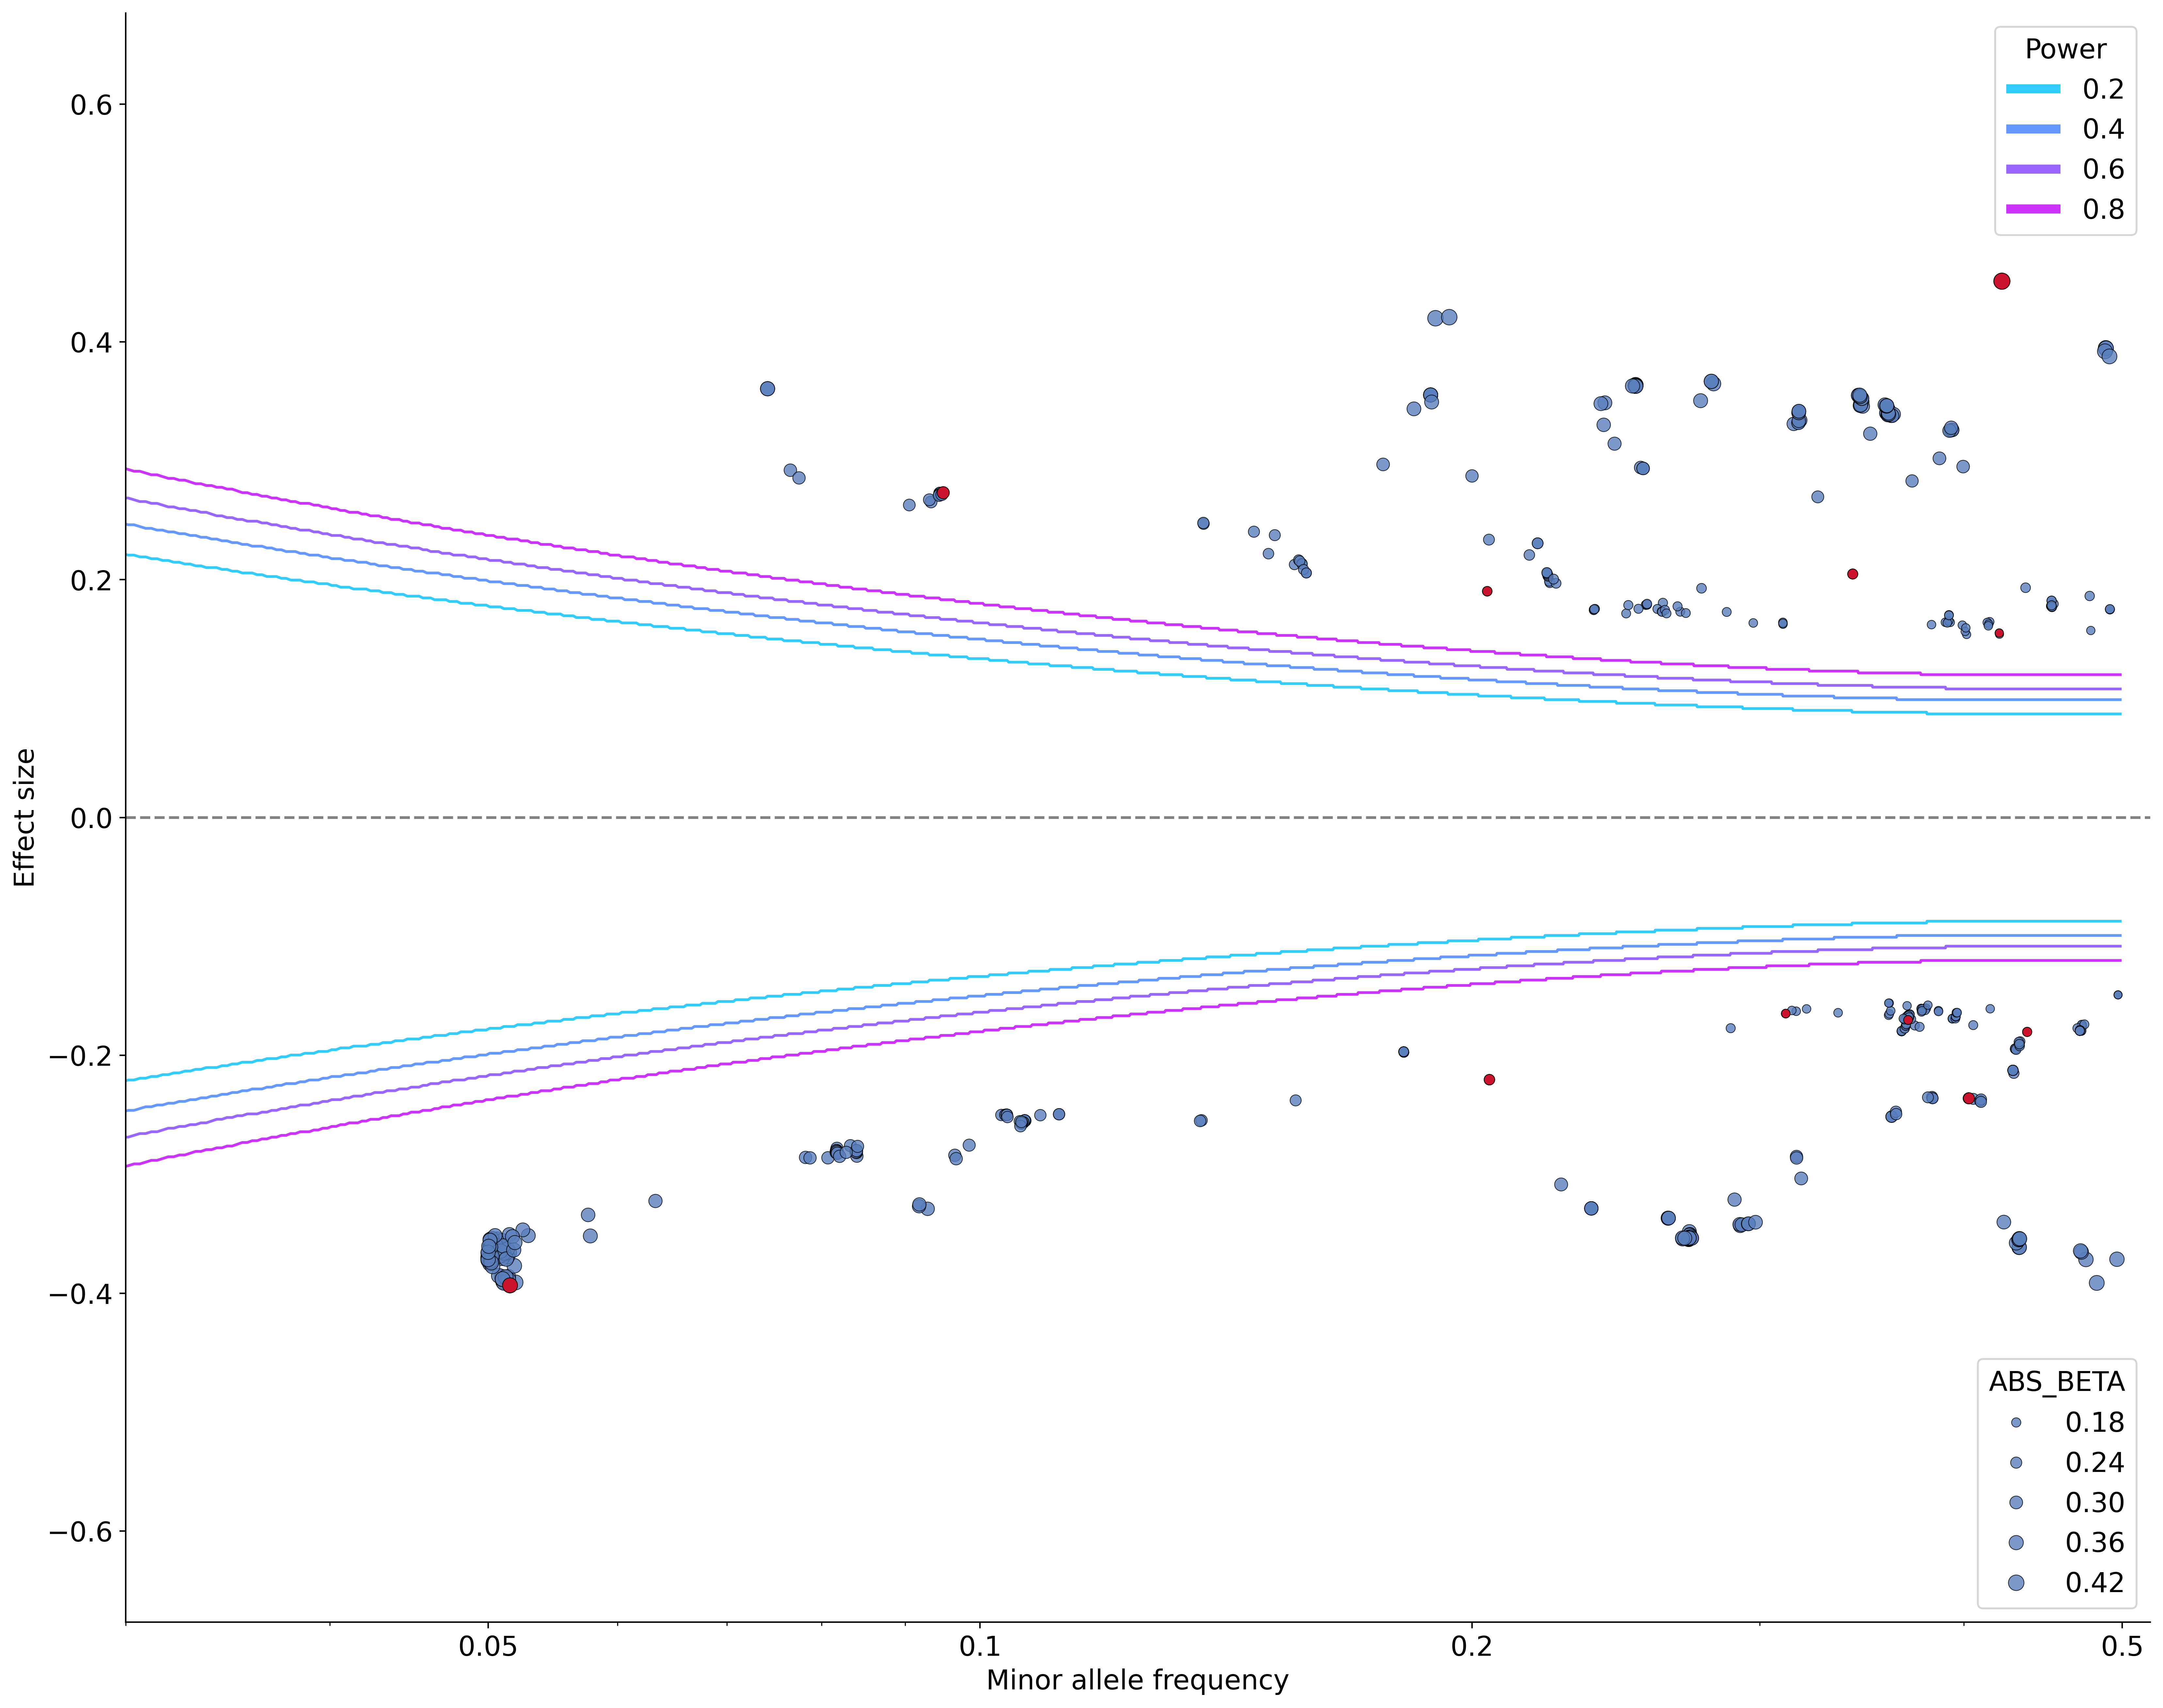

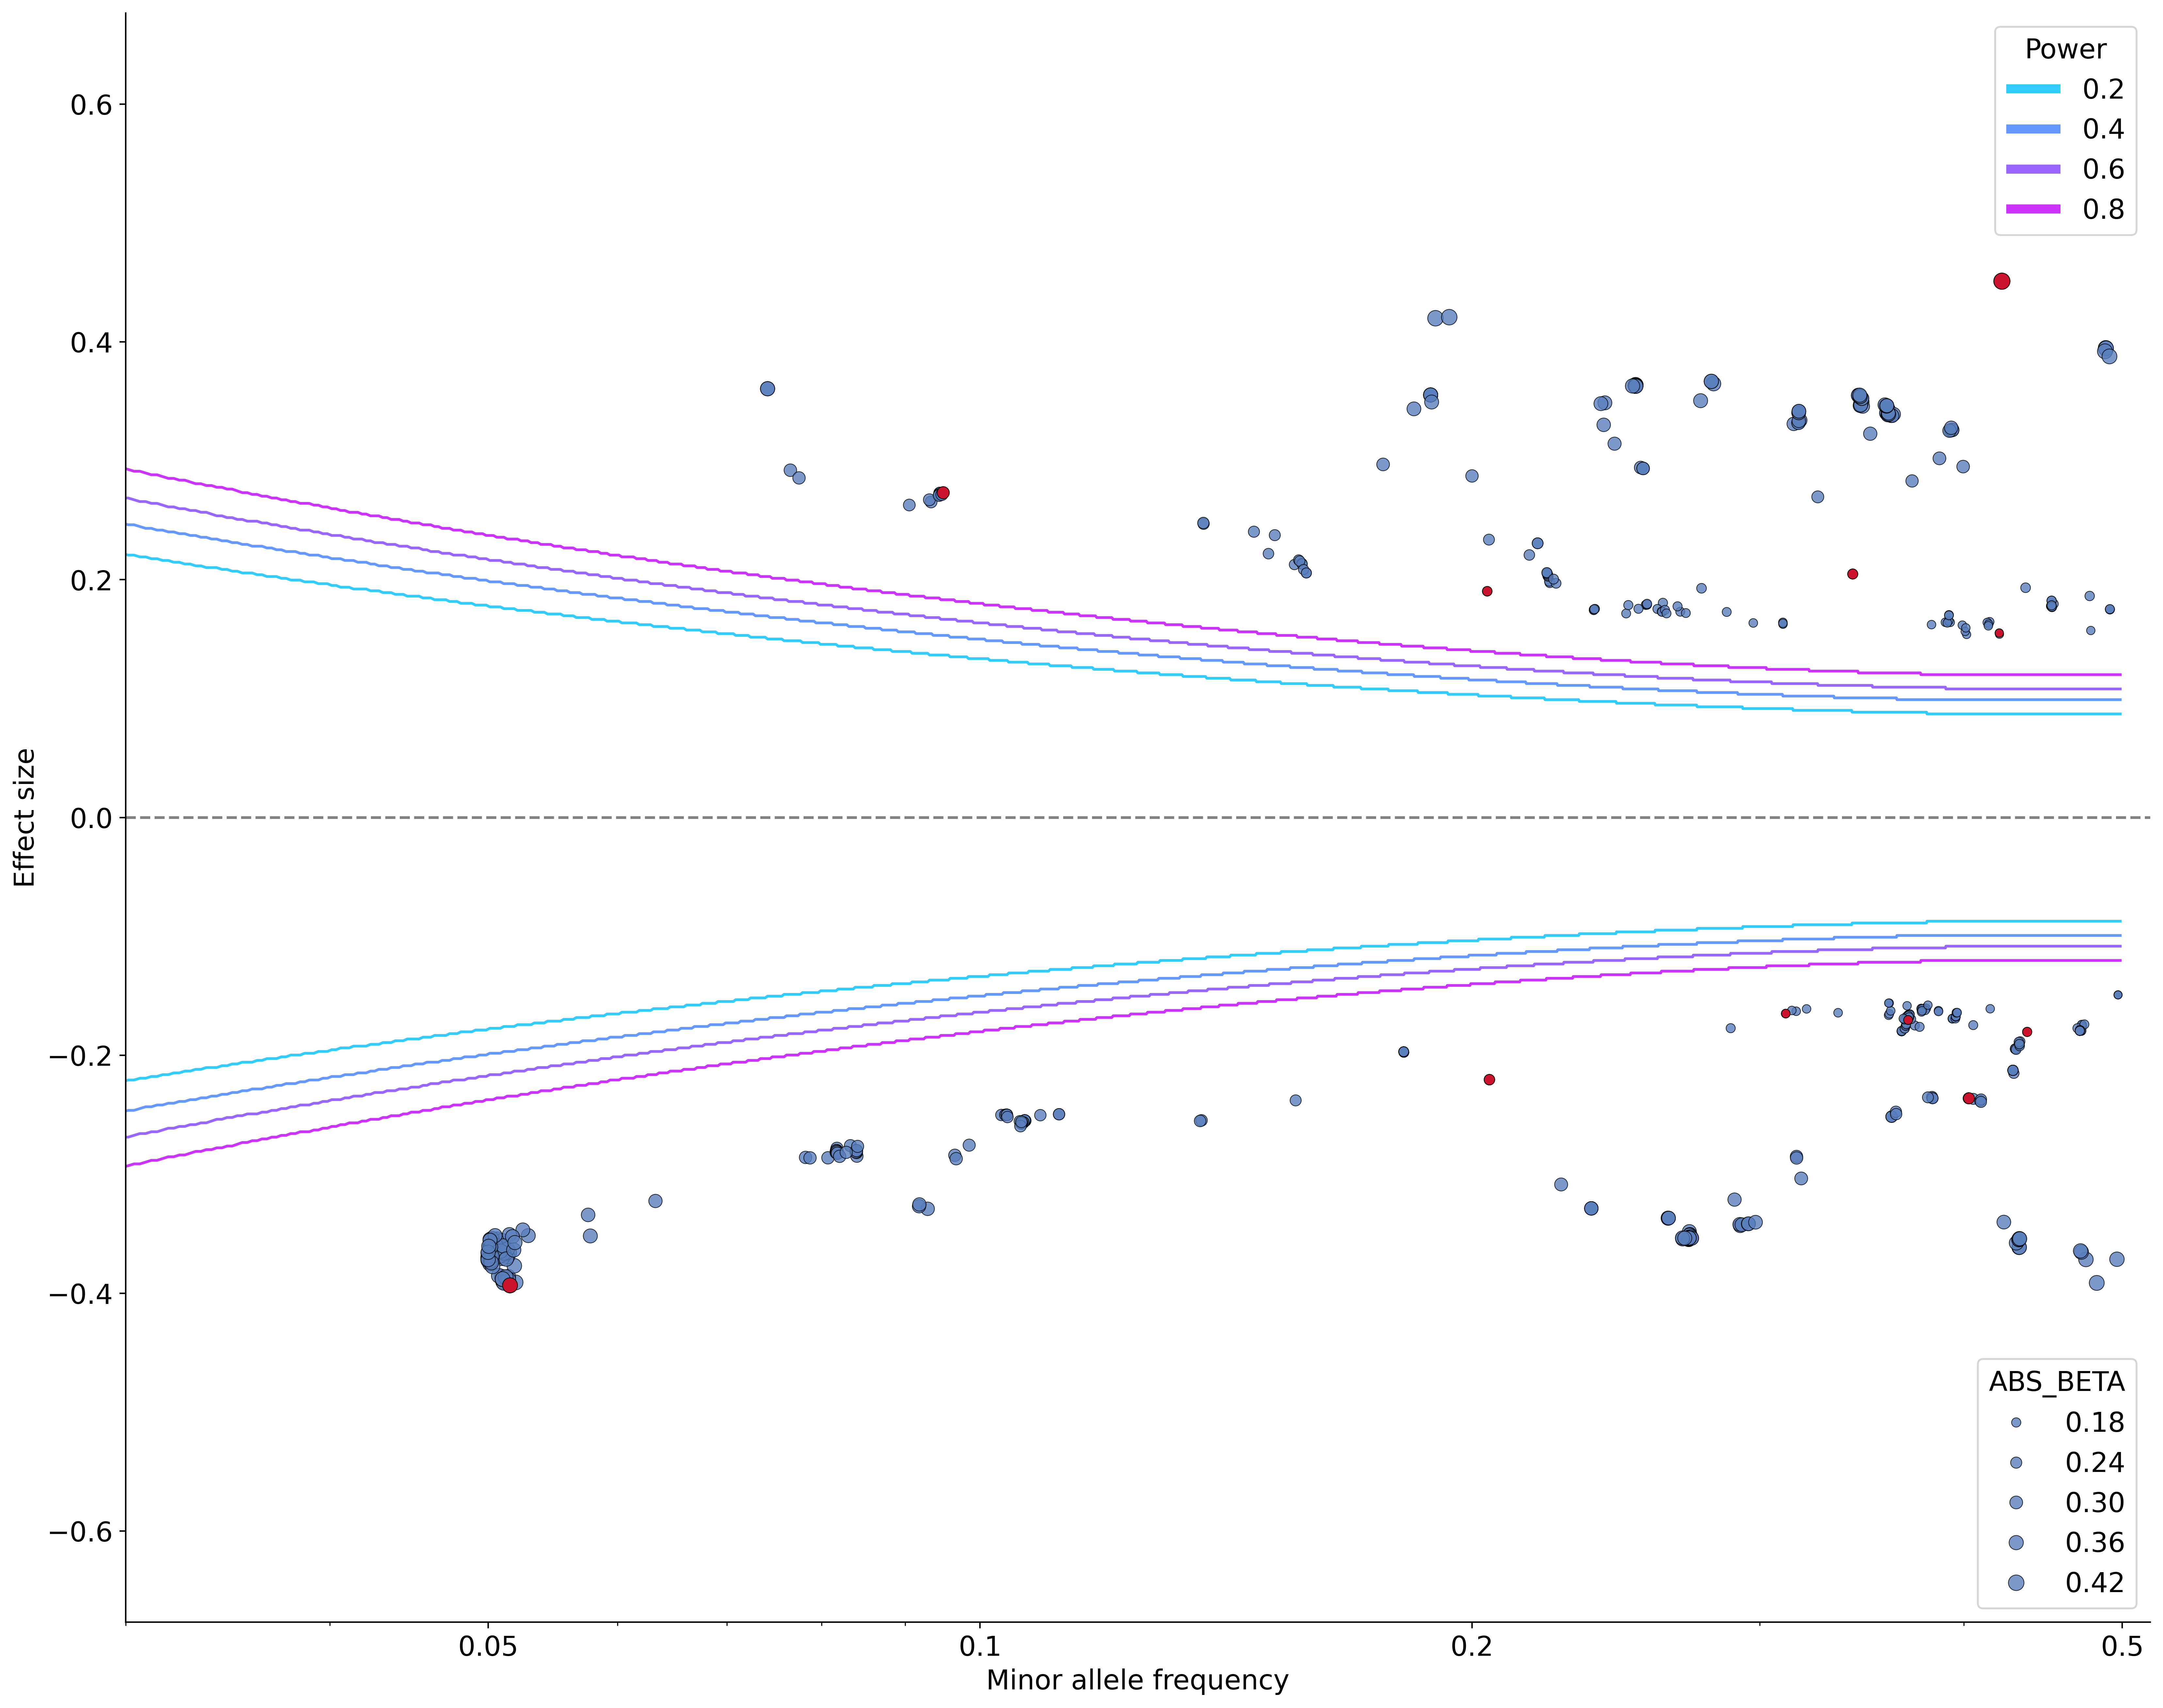

In [4]:
plottrumpet(
    mysumstats=mysumstats.data,
    mode="b", 
    n_matrix=2000, 
    ncase=48060, 
    ncontrol=6364, 
    prevalence=0.05,
    figargs={"figsize": (20, 16), "dpi": 400},
    font_family='DejaVu Sans',
    highlight=highlighted['SNPID'].tolist(),
    #anno_x=None,
    #anno_y=None,
    highlight_windowkb = 0.01,
    anno=True,
    ylim=(-mysumstats.data['BETA'].abs().max()*1.5, mysumstats.data['BETA'].abs().max()*1.5),
    xlim=(mysumstats.data['MAF'].min()*0.6,0.52)
)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import scipy as sp
from matplotlib.collections import LineCollection
import matplotlib.colors as mc
import matplotlib
from adjustText import adjust_text
from gwaslab.util_in_get_sig import annogene
from gwaslab.viz_aux_annotate_plot import annotate_single
from gwaslab.viz_aux_reposition_text import adjust_text_position
from gwaslab.viz_aux_save_figure import save_figure
from gwaslab.viz_plot_mqqplot import _process_highlight
from gwaslab.g_Log import Log
from gwaslab.util_in_calculate_power import get_beta
from gwaslab.util_in_calculate_power import get_power
from gwaslab.util_in_calculate_power import get_beta_binary
from gwaslab.util_in_fill_data import filldata

def experiment_plottrumpet(mysumstats,
                snpid="SNPID",
                mode="q",
                chrom="CHR",
                pos="POS",
                n="N",
                p="P",
                maf="MAF",
                eaf="EAF",
                beta="BETA",
                ts=None,
                anno=None,
                prevalence=None,
                or_to_rr=False,
                ncase=None,
                ncontrol=None, 
                sig_level=5e-8,
                p_level=5e-8,
                anno_y = 1,
                anno_x = 0.01,                
                maf_range=None,
                beta_range=None, 
                n_matrix=1000,
                xscale="log",
                yscale_factor=1,
                cmap="cool",
                ylim=None,
                xlim=None,
                markercolor="#597FBD",
                hue=None,
                highlight = None,
                highlight_chrpos = False,
                highlight_color="#CB132D",
                highlight_windowkb = 500,
                highlight_anno_args = None,
                pinpoint= None,
                pinpoint_color ="red",
                scatter_args=None,
                fontsize=15,
                font_family="Arial",
                size= "ABS_BETA",
                sizes=None,
                save=False,
                save_args=None,
                figargs=None,
                build="99",
                anno_set=None,
                anno_alias=None,
                anno_d=None,
                anno_args=None,
                anno_style="expand",
                anno_source = "ensembl",
                anno_max_iter=100,
                arm_scale=1,
                repel_force=0.01,
                ylabel="Effect size",
                xlabel="Minor allele frequency",
                xticks = None,
                xticklabels = None,
                yticks = None,
                yticklabels=None,
                sort="beta",
                verbose=True,
                log=Log()):
    
    #Checking columns#################################################################################################################
    matplotlib.rc('font', family=font_family)
    if sizes is None:
        sizes = (20,80)
    if anno_args is None:
        anno_args={"fontsize":12,"fontstyle":"italic"}
    if anno_set is None:
        anno_set=list()
    if anno_alias is None:
        anno_alias=dict()
    if anno_d is None:
        anno_d=dict()
    if ts is None:
        ts = [0.2,0.4,0.6,0.8]
    if xticks is None:
        if xscale== "log":
            xticks = [0.001,0.01,0.05,0.1,0.2,0.5]
            xticklabels = xticks
        else:
            xticks = [0,0.01,0.05,0.1,0.2,0.5]
            xticklabels = xticks            
    if figargs is None:
        figargs={"figsize":(10,8)}
    if scatter_args is None:
        scatter_args ={}
    if hue is not None:
        scatter_args["hue"]=hue
    if markercolor is not None:
        scatter_args["color"]=markercolor
    if highlight is None:
        highlight = list()
    if pinpoint is None:
        pinpoint = list()  
    #Checking columns#################################################################################################################
    log.write("Start to create trumpet plot...", verbose=verbose)
    
    #parameter check##################################################################################################################
    if (beta not in mysumstats.columns) or (eaf not in mysumstats.columns):
        log.write(" -No EAF or BETA columns. Skipping...", verbose=verbose)
        return None
    if mode=="b":
        if ncase is None or ncontrol is None:
            log.write(" -No ncase or ncontrol. Skipping...", verbose=verbose)
            return None
        if prevalence is None:
                prevalence= ncase/(ncase + ncontrol)
                log.write(" -Prevalence is not given. Estimating based on ncase and ncontrol :{}...".format(prevalence), verbose=verbose)
    
    #print settings##################################################################################################################

    log.write(" -Settings:", verbose=verbose)
    log.write("  -Mode: {}".format(mode), verbose=verbose)
    if mode == "q" :
        log.write("  -N: {}".format(n), verbose=verbose)
    if mode == "b" :
        log.write("  -N_CASE: {}".format(ncase), verbose=verbose)
        log.write("  -N_CONTROL: {}".format(ncontrol), verbose=verbose)
        log.write("  -PREVALENCE: {}".format(prevalence), verbose=verbose)
    log.write("  -BETA: {}".format(beta), verbose=verbose)
    log.write("  -Significance level: {}".format(sig_level), verbose=verbose)
    log.write("  -Power thresholds: {}".format(ts), verbose=verbose)
    log.write("  -Power line smoothness: {}".format(n_matrix), verbose=verbose)
    
    #loading columns #################################################################################################################
    cols_to_use = [snpid, beta, eaf, n, p]
    
    if len(highlight)>0: 
        cols_to_use.append(pos)
        cols_to_use.append(chrom)
    
    if anno is not None:
        if anno != "GENENAME":
            if anno!=True:
                log.write(" -Loading column {} for annotation...".format(anno), verbose=verbose)
                if anno not in cols_to_use:
                    cols_to_use.append(anno)
        else:
            cols_to_use.append(pos) if pos not in cols_to_use else cols_to_use
            cols_to_use.append(chrom) if chrom not in cols_to_use else cols_to_use

    print('columns', cols_to_use)

    if size != "ABS_BETA":
        if size not in cols_to_use:
            cols_to_use.append(size)
    if "hue" in scatter_args.keys():
        cols_to_use.append(scatter_args["hue"]) 
    #filter by p #################################################################################################################
    if p in mysumstats.columns:
        sumstats = mysumstats.loc[mysumstats[p]< p_level,cols_to_use ].copy()
        log.write(" -Excluding variants with P values > {}".format(p_level), verbose=verbose)
    else:
        cols_to_use.remove(p)
        sumstats = mysumstats[[beta,eaf,n]].copy()
    log.write(" -Plotting {} variants...".format(len(sumstats)), verbose=verbose)
    
    #add maf column #################################################################################################################
    if maf not in sumstats.columns:
        sumstats = filldata(sumstats,to_fill=["MAF"],verbose=False)
        is_filpped = (sumstats["MAF"] < sumstats[eaf]) & (sumstats[eaf] > 0.5)& (sumstats["MAF"] < 0.5)
        log.write(" -Flipping {} variants...".format(sum(is_filpped)), verbose=verbose)
        sumstats.loc[is_filpped, beta] = -sumstats.loc[is_filpped, beta]
    
    #configure n #################################################################################################################
    if mode=="q":
        if n == "N":
            n = sumstats["N"].median() 
        elif n == "max":
            n = sumstats["N"].max() 
        elif n == "min":
            n = sumstats["N"].min() 
        elif n == "median":
            n = sumstats["N"].median() 
        elif n == "mean":
            n = sumstats["N"].mean() 
        log.write(" -N for power calculation: {}".format(n), verbose=verbose)

    #configure beta and maf range ###################################################################################################
    if maf_range is None:
        maf_min_power = np.floor( -np.log10(sumstats[maf].min())) + 1
        maf_range=(min(np.power(10.0,-maf_min_power),np.power(10.0,-4)),0.5)
    if beta_range is None:
        if sumstats[beta].max()>3:
            beta_range=(0.0001,sumstats[beta].max())
        else:
            beta_range=(0.0001,3)
    
    #configure power threshold###################################################################################################
    if ts is None:
        ts=[0.3,0.5,0.8]
    
    #configure colormap##########################################################################################################
    cmap_to_use = plt.cm.get_cmap(cmap)
    if cmap_to_use.N >100:
        rgba = cmap_to_use(ts)
    else:
        rgba = cmap_to_use(range(len(ts)))
    
    output_hex_colors=[]
    for i in range(len(rgba)):
        output_hex_colors.append(mc.to_hex(rgba[i]))
    output_hex_colors

    if len(highlight)>0:
        sumstats["HUE"] = pd.NA
        sumstats["HUE"] = sumstats["HUE"].astype("Int64")
        sumstats = _process_highlight(sumstats=sumstats, 
                                                    highlight=highlight, 
                                                    highlight_chrpos=highlight_chrpos, 
                                                    highlight_windowkb=highlight_windowkb, 
                                                    snpid=snpid, 
                                                    chrom=chrom, 
                                                    pos=pos)
    ##################################################################################################
    fig, ax = plt.subplots(**figargs)
    
    ##creating power line############################################################################################
    if mode=="q":
        for i,t in enumerate(ts):
            xpower = get_beta(mode="q",          
                            eaf_range=maf_range,
                            beta_range=beta_range, 
                            n=n,
                            t=t,
                            sig_level=sig_level,
                            n_matrix=n_matrix)
            xpower2 = xpower.copy()
            xpower2[1] = -xpower2[1] 
            xpower2[1] = xpower2[1] * yscale_factor
            xpower[1] = xpower[1] * yscale_factor
            lines = LineCollection([xpower2,xpower], label=t,color=output_hex_colors[i],zorder=0)
            ax.add_collection(lines)
    else:
        for i,t in enumerate(ts):
            xpower = get_beta_binary(        
                            eaf_range=maf_range,
                            beta_range=beta_range, 
                            prevalence=prevalence,
                            or_to_rr = or_to_rr,
                            ncase=ncase, 
                            ncontrol=ncontrol, 
                            t=t,
                            sig_level=sig_level,
                            n_matrix=n_matrix)
            xpower2 = xpower.copy()
            xpower2[1] = -xpower2[1] 
            xpower2[1] = xpower2[1] * yscale_factor
            xpower[1] = xpower[1] * yscale_factor
            lines = LineCollection([xpower2,xpower], label=t,color=output_hex_colors[i])
            ax.add_collection(lines)


    ###################################################################################################
    # get abs  and convert using scaling factor
    sumstats[beta] = sumstats[beta]*yscale_factor
    sumstats["ABS_BETA"] = sumstats[beta].abs()

    ##################################################################################################
    size_norm = (sumstats["ABS_BETA"].min(), sumstats["ABS_BETA"].max())
    ## if highlight  ##################################################################################################
    dots = sns.scatterplot(data=sumstats,
                    x=maf,
                    y=beta,
                    size=size, 
                    ax=ax, 
                    sizes=sizes,
                    size_norm=size_norm,
                    legend=True, 
                    edgecolor="black",
                    alpha=0.8,
                    zorder=2,
                    **scatter_args)
    
    if len(highlight) >0:
        
        legend = None
        style=None
        linewidth=0
        edgecolor="black"

        if pd.api.types.is_list_like(highlight[0]) and highlight_chrpos==False:
            for i, highlight_set in enumerate(highlight):
                scatter_args["color"]=highlight_color[i%len(highlight_color)]
                log.write(" -Highlighting set {} target loci...".format(i+1),verbose=verbose)
                sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==i], x=maf,
                    y=beta,
                    legend=legend,
                    style=style,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    linewidth=linewidth,
                    zorder=3+i,
                    ax=ax,edgecolor=edgecolor,**scatter_args)  

        else:
            log.write(" -Highlighting target loci...",verbose=verbose)
            scatter_args["color"]=highlight_color
            sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==0], x=maf,
                    y=beta,
                legend=legend,
                size=size,
                sizes=sizes,
                size_norm=size_norm,
                zorder=3,
                ax=ax,
                edgecolor="black",
                **scatter_args)  
    ####################################################################################################################
    if len(pinpoint)>0:
        legend = None
        style=None
        linewidth=0
        edgecolor="black"
        if pd.api.types.is_list_like(pinpoint[0]):

            for i, pinpoint_set in enumerate(pinpoint):
                scatter_args["color"]=pinpoint_color[i%len(pinpoint_color)]
                if sum(sumstats[snpid].isin(pinpoint_set))>0:
                    to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint_set),:]
                    log.write(" -Pinpointing set {} target vairants...".format(i+1),verbose=verbose)
                    sns.scatterplot(data=to_pinpoint, 
                    x=maf,
                    y=beta,
                    legend=legend,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    zorder=3,
                    ax=ax,
                    edgecolor="black",
                    **scatter_args)  
                    #ax.scatter(to_pinpoint[maf],to_pinpoint[beta],color=pinpoint_color[i%len(pinpoint_color)],zorder=100,s=to_pinpoint[size])
                else:
                    log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
        else:
            scatter_args["color"]=pinpoint_color
            if sum(sumstats[snpid].isin(pinpoint))>0:
                to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint),:]
                log.write(" -Pinpointing target vairants...",verbose=verbose)
                sns.scatterplot(data=to_pinpoint, x=maf,
                    y=beta,
                    legend=legend,
                    size=size,
                    sizes=sizes,
                    size_norm=size_norm,
                    zorder=3,
                    ax=ax,
                    edgecolor="black",
                    **scatter_args)  
                #ax.scatter(to_pinpoint[maf],to_pinpoint[beta],color=pinpoint_color[i%len(pinpoint_color)],zorder=100,s=to_pinpoint[size])
            else:
                log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
    
    ####################################################################################################################
    
    #second_legend = ax.legend(title="Power", loc="upper right",fontsize =fontsize,title_fontsize=fontsize)
    
    h,l = ax.get_legend_handles_labels()
    if len(ts)>0:
        l1 = ax.legend(h[:int(len(ts))],l[:int(len(ts))], title="Power", loc="upper right",fontsize =fontsize,title_fontsize=fontsize)
        for line in l1.get_lines():
            line.set_linewidth(5.0)
    if hue is None:
        l2 = ax.legend(h[int(len(ts)):],l[int(len(ts)):], title=size, loc="lower right",fontsize =fontsize,title_fontsize=fontsize)
    else:
        l2 = ax.legend(h[int(len(ts)):],l[int(len(ts)):], title=None, loc="lower right",fontsize =fontsize,title_fontsize=fontsize)
    if len(ts)>0:
        ax.add_artist(l1)
    #first_legend = ax.legend(handles=dots, loc="lower right" ,title=size,fontsize =fontsize,title_fontsize=fontsize)
    #ax.add_artist(first_legend)
    ##################################################################################################

    ax.tick_params(axis='y', labelsize=fontsize)

    ax.axhline(y=0,color="grey",linestyle="dashed")
    
    if xscale== "log":
        ax.set_xscale('log')
        rotation=0
        ax.set_xticks(xticks,xticklabels,fontsize=fontsize,rotation=rotation)
        ax.set_xlim(min(sumstats[maf].min()/2,0.001/2),0.52)
    else:
        rotation=90    
        ax.set_xticks(xticks,xticklabels,fontsize=fontsize,rotation=rotation)
        ax.set_xlim(-0.02,0.52)
        
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)

    if yticks is not None:
        ax.set_yticks(yticks, yticklabels)

    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(xlabel,fontsize=fontsize)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)

    ############  Annotation ##################################################################################################
    if len(anno_set)>0:
        variants_toanno = sumstats[sumstats[snpid].isin(anno_set)].reset_index(drop=True)
        if (variants_toanno.empty is not True):
            variants_toanno = annogene(variants_toanno,
                                    id="rsID",
                                    chrom=chrom,
                                    pos=pos,
                                    log=log,
                                    build=build,
                                    source=anno_source,
                                    verbose=verbose).rename(columns={"GENE":"GENENAME"})
            
        texts_u=[]
        texts_d=[]

        if len(variants_toanno)>0:
            maxy = variants_toanno[beta].abs().max()
            variants_toanno["ADJUSTED_i"] = np.nan 
            y_span = 0.5
                
            if sort == "beta" : 
                variants_toanno = variants_toanno.sort_values(by=beta, key= np.abs, ascending = False)
            else:
                variants_toanno = variants_toanno.sort_values(by=maf, key= np.abs, ascending = True)
                
            if anno_style == "expand":

                min_factor=None
                    
                if len(variants_toanno.loc[variants_toanno[beta]>0, "ADJUSTED_i"])>1:
                        variants_toanno.loc[variants_toanno[beta]>0, "ADJUSTED_i"] = adjust_text_position(variants_toanno.loc[variants_toanno[beta]>0,maf].values.copy(), 
                                                                                y_span, 
                                                                                repel_force=repel_force,
                                                                                max_iter=anno_max_iter,
                                                                                log=log,
                                                                                amode=xscale,
                                                                                verbose=verbose,min_factor=min_factor)

                if len(variants_toanno.loc[variants_toanno[beta]<0, "ADJUSTED_i"])>1:
                        variants_toanno.loc[variants_toanno[beta]<0, "ADJUSTED_i"] = adjust_text_position(variants_toanno.loc[variants_toanno[beta]<0,maf].values.copy(), 
                                                                y_span, 
                                                                repel_force=repel_force,
                                                                max_iter=anno_max_iter,
                                                                log=log,
                                                                amode=xscale,
                                                                verbose=verbose,min_factor=min_factor)

                
            for variants_toanno_half in [variants_toanno.loc[variants_toanno[beta]<0,:], variants_toanno.loc[variants_toanno[beta]>0,:]]:
                if len(variants_toanno_half)<1:
                    continue
                last_pos = min(variants_toanno_half[maf])/2
                for index, row in variants_toanno_half.iterrows():
                    
                    armB_length_in_point = ax.transData.transform((0,1.1*maxy))[1]-ax.transData.transform((0, abs(row[beta])))[1]
                    armB_length_in_point = armB_length_in_point*arm_scale

                    if anno_style == "right" :
                        #right style
                        if row[maf]>last_pos*(repel_force+1):
                            last_pos=row[maf]
                        else:
                            last_pos*= (repel_force+1)
                    elif anno_style == "expand" :
                        last_pos = row["ADJUSTED_i"]

                    if anno_style == "right"  or anno_style == "expand":
                        if row[beta] >0 :
                            texts_u.append(ax.annotate(row[anno], xy=(row[maf], row[beta]),xytext=(last_pos , 1.2*maxy),
                                                    arrowprops=dict(relpos=(0,0),arrowstyle="-|>",linestyle='--', facecolor='black',connectionstyle="arc,angleA=-90,armA={},angleB=0,armB=0,rad=0".format(armB_length_in_point)),rotation=90,
                                                    ha="left",va="bottom",**anno_args))
                        else:
                            texts_d.append(ax.annotate(row[anno], xy=(row[maf], row[beta]),xytext=(last_pos , -1.2*maxy),
                                                    arrowprops=dict(relpos=(0,1),arrowstyle="-|>", linestyle='--',facecolor='black',connectionstyle="arc,angleA=90,armA={},angleB=0,armB=0,rad=0".format(armB_length_in_point)),rotation=90,
                                                    ha="left",va="top",**anno_args))
                        
                    if anno_style=="tight":
                        texts_d.append(ax.text(row[maf], row[beta], row[anno]))

            if anno_style=="tight":
                adjust_text(texts_d, 
                            autoalign =True,
                            precision =0.001,
                            lim=1000, 
                            expand_text=(0.5,0.5), 
                            expand_points=(0.5,0.5),
                            force_objects=(0.5,0.5), 
                            ax=ax)
        
    ############  Annotation ##################################################################################################
    if mode=="q":
        save_figure(fig, save, keyword="trumpet_q",save_args=save_args, log=log, verbose=verbose)
    elif mode=="b":
        save_figure(fig, save, keyword="trumpet_b",save_args=save_args, log=log, verbose=verbose)

    log.write("Finished creating trumpet plot!", verbose=verbose)
    return None

####################################################################


2024/10/15 16:12:18 Start to create trumpet plot...
2024/10/15 16:12:18  -Settings:
2024/10/15 16:12:18   -Mode: b
2024/10/15 16:12:18   -N_CASE: 4806
2024/10/15 16:12:18   -N_CONTROL: 6364
2024/10/15 16:12:18   -PREVALENCE: 0.05
2024/10/15 16:12:18   -BETA: BETA
2024/10/15 16:12:18   -Significance level: 5e-08
2024/10/15 16:12:18   -Power thresholds: [0.2, 0.4, 0.6, 0.8]
2024/10/15 16:12:18   -Power line smoothness: 2000
columns ['SNPID', 'BETA', 'EAF', 'N', 'P', 'POS', 'CHR']
2024/10/15 16:12:19  -Excluding variants with P values > 5e-08
2024/10/15 16:12:19  -Plotting 880 variants...
2024/10/15 16:12:19  -Flipping 0 variants...
2024/10/15 16:12:19  -Updating eaf-beta matrix...
2024/10/15 16:12:19  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....


/tmp/ipykernel_15850/3109578457.py:220: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_to_use = plt.cm.get_cmap(cmap)


2024/10/15 16:12:20  -Extracting eaf-beta combinations with power = 0.2...
2024/10/15 16:12:20  -Updating eaf-beta matrix...
2024/10/15 16:12:20  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:21  -Extracting eaf-beta combinations with power = 0.4...
2024/10/15 16:12:21  -Updating eaf-beta matrix...
2024/10/15 16:12:21  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:22  -Extracting eaf-beta combinations with power = 0.6...
2024/10/15 16:12:22  -Updating eaf-beta matrix...
2024/10/15 16:12:22  -GRR is approximated using OR. For prevalence < 10%, GRR is very similar to OR....
2024/10/15 16:12:23  -Extracting eaf-beta combinations with power = 0.8...
2024/10/15 16:12:23  -Highlighting target loci...
2024/10/15 16:12:23 Start to annotate variants with nearest gene name(s)...
2024/10/15 16:12:23  -Assigning Gene name using ensembl_hg38_gtf for protein coding genes
2024/10/15 16:12:23 Fi

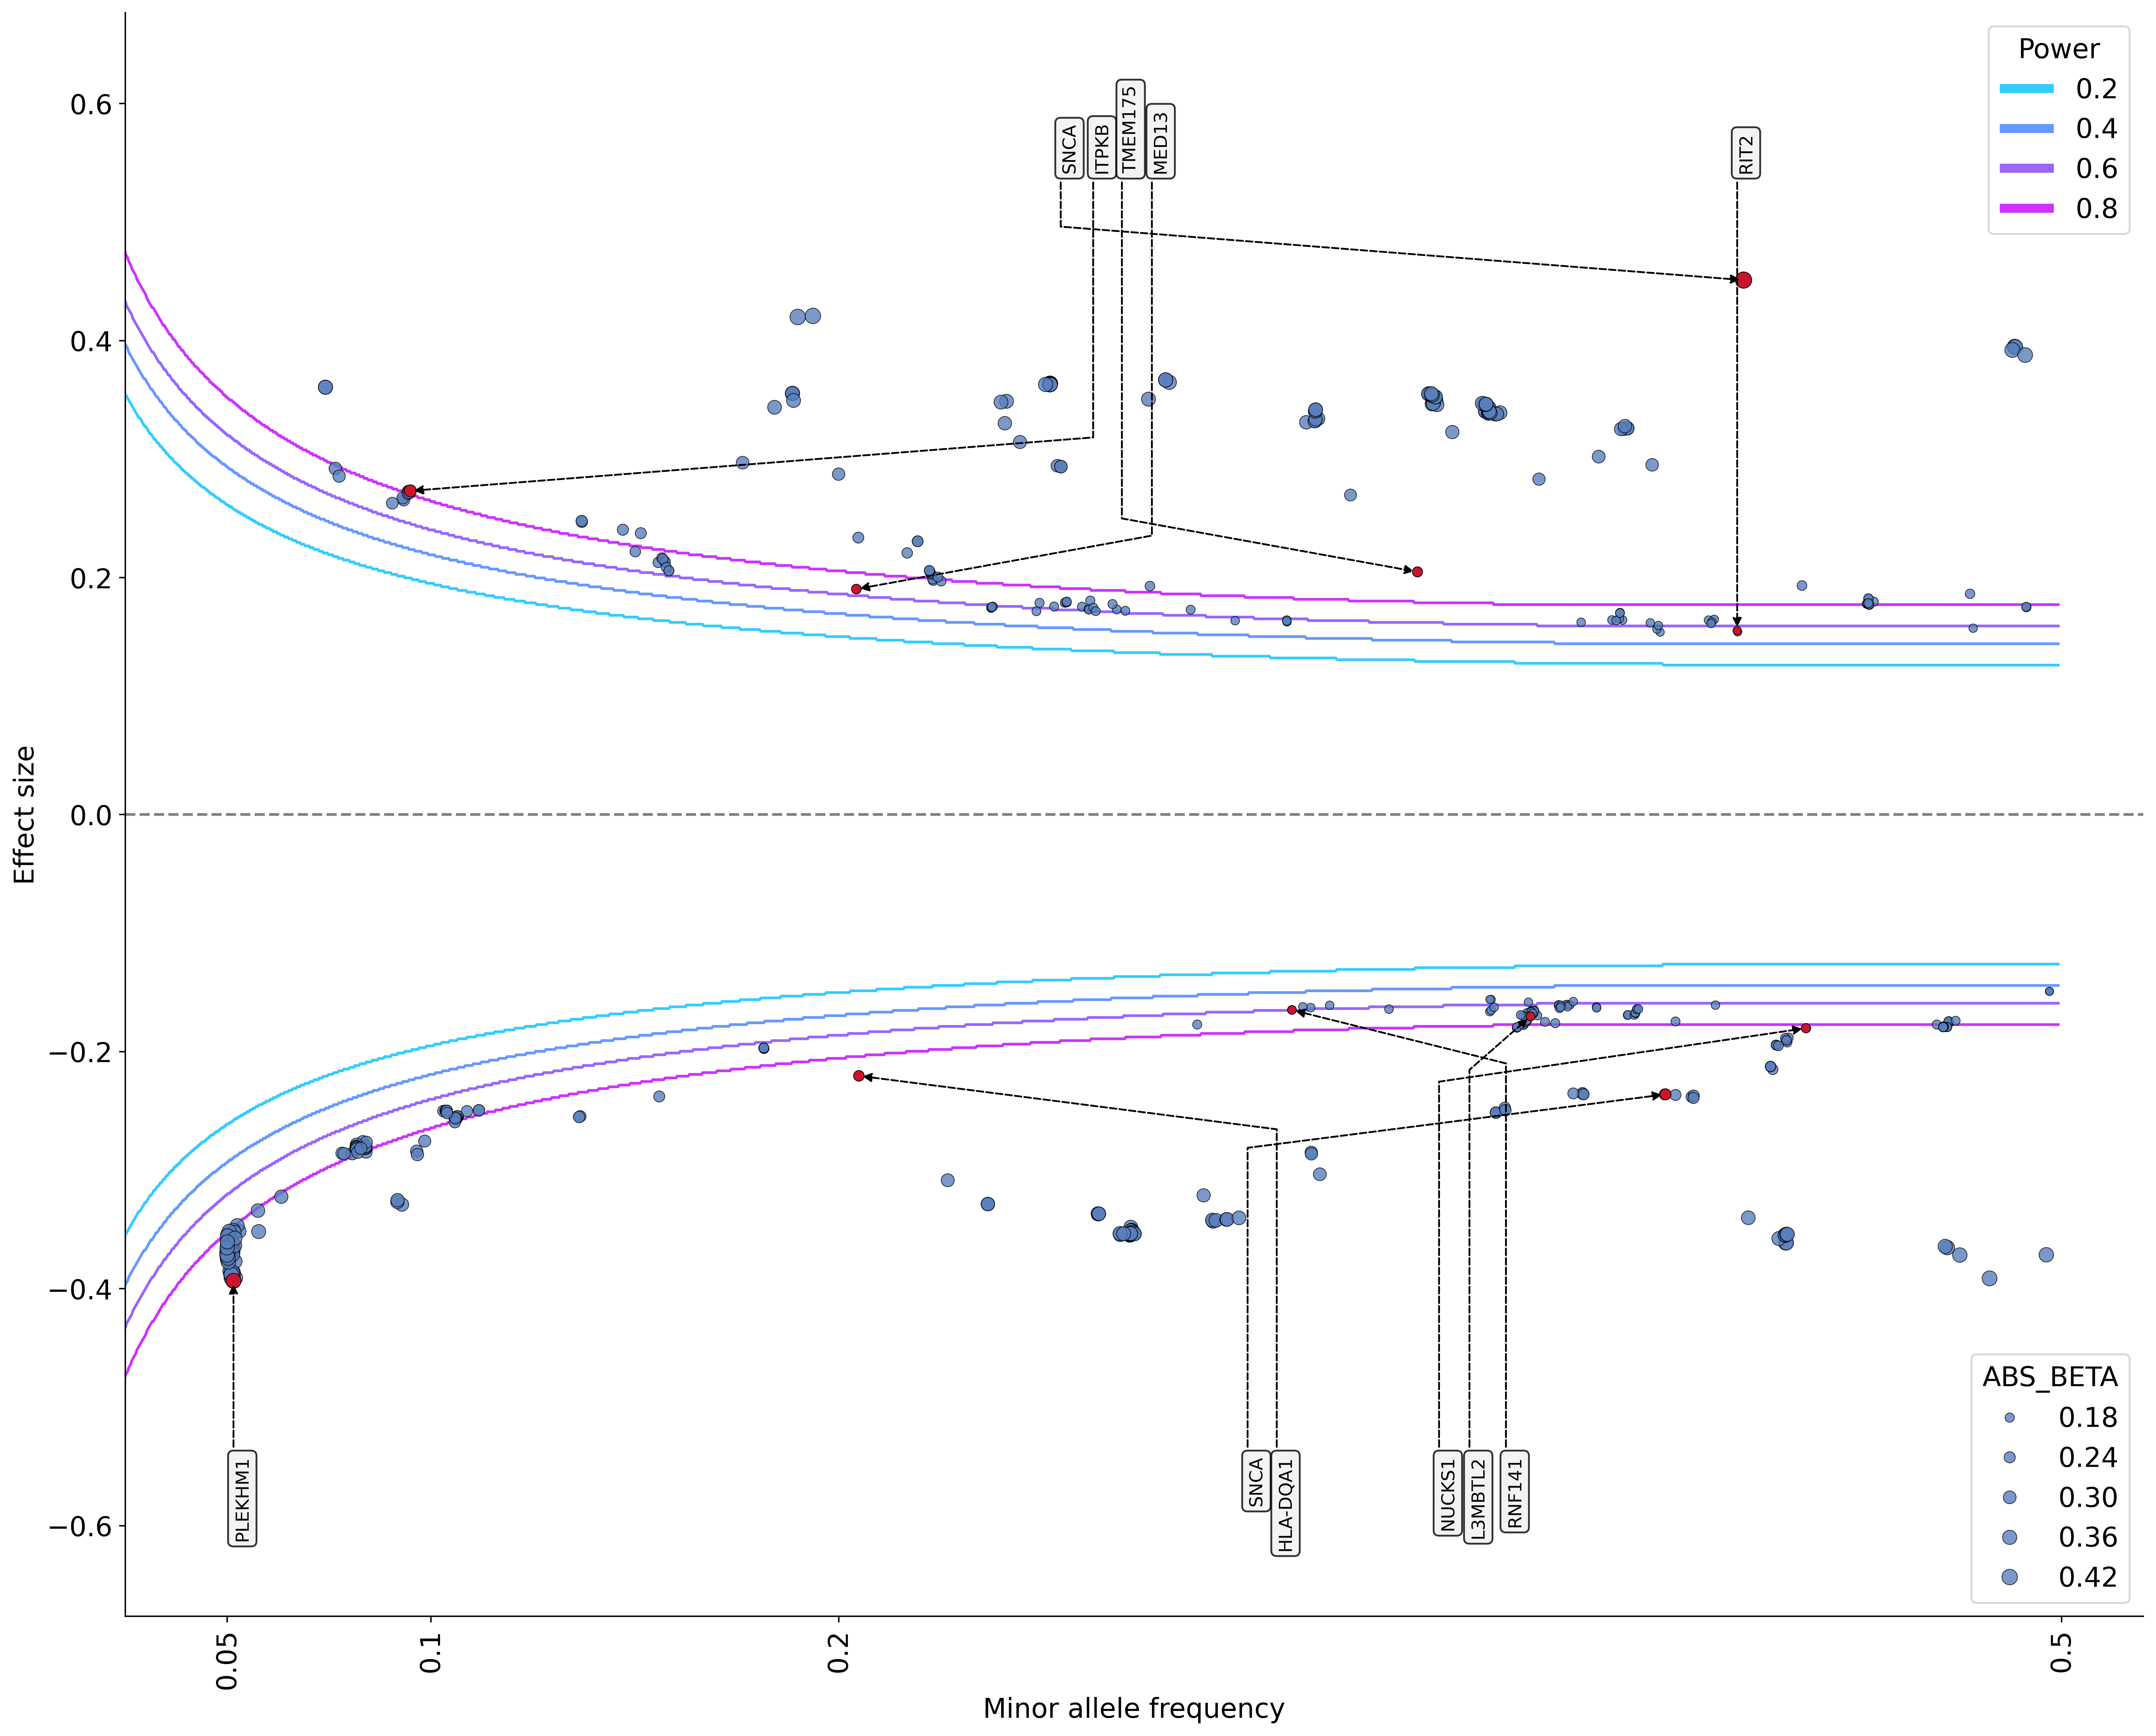

In [6]:
experiment_plottrumpet(
    mysumstats=mysumstats.data,
    mode="b",
    xscale='nonlog',
    n_matrix=2000, 
    ncase=4806, 
    ncontrol=6364, 
    prevalence=0.05,
    figargs={"figsize": (20, 16), "dpi": 400},
    font_family='DejaVu Sans',
    highlight=highlighted['SNPID'].tolist(),
    highlight_windowkb = 0.01,
    anno="GENENAME",
    build="38",
    anno_set=highlighted['SNPID'].tolist(),
    anno_style="expand",
    ylim=(-mysumstats.data['BETA'].abs().max()*1.5, mysumstats.data['BETA'].abs().max()*1.5),
    xlim=(mysumstats.data['MAF'].min()*0.5,0.52),
    anno_args={'bbox':dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='#f0f0f0', alpha=0.8)},
    save=True
)

In [7]:
annogene(
    insumstats=highlighted.drop(columns=['GENE']),
    id="rsID",
    chrom="CHR",
    pos="POS",
    build='38'
)

2024/10/15 16:12:26 Start to annotate variants with nearest gene name(s)...
2024/10/15 16:12:26  -Assigning Gene name using ensembl_hg38_gtf for protein coding genes
2024/10/15 16:12:26 Finished annotating variants with nearest gene name(s) successfully!


,SNP,rsID,SNPID,CHR,POS,LOCATION,GENE
0,rs3747973,rs3747973,1:205708020:A:G,1,205708020,4802,NUCKS1
1,rs74990530,rs74990530,1:226728477:T:A,1,226728477,0,ITPKB
2,rs34311866,rs34311866,4:958159:C:T,4,958159,0,TMEM175
3,rs356182,rs356182,4:89704960:G:A,4,89704960,0,SNCA
4,rs7681440,rs7681440,4:89835399:C:G,4,89835399,0,SNCA
5,rs1846190,rs1846190,6:32616036:A:G,6,32616036,12143,HLA-DQA1
6,rs4909940,rs4909940,11:10521749:T:C,11,10521749,0,RNF141
7,rs56328224,rs56328224,17:45495053:T:C,17,45495053,-4295,PLEKHM1
8,rs72843781,rs72843781,17:62016181:C:A,17,62016181,0,MED13
9,rs8087199,rs8087199,18:43094076:A:G,18,43094076,0,RIT2
